In [1]:
import pandas as pd
import numpy as np
import spacy

import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt

from urllib.request import urlopen

In [2]:
from collections import Counter,OrderedDict

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Q1

## Chess Transfers

For this question we are going to use the following dataset:

In [4]:
chess = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/chess-transfers/transfers.csv')
chess

,url,ID,Federation,Form.Fed,Transfer Date
0,https://ratings.fide.com/fedchange.phtml?year=...,2019221,USA,PHI,12/15/00
1,https://ratings.fide.com/fedchange.phtml?year=...,14401754,BIH,CRO,1/31/00
2,https://ratings.fide.com/fedchange.phtml?year=...,14401762,BIH,YUG,1/31/00
3,https://ratings.fide.com/fedchange.phtml?year=...,2019221,USA,PHI,12/15/00
4,https://ratings.fide.com/fedchange.phtml?year=...,14401754,BIH,CRO,1/31/00
...,...,...,...,...,...
927,https://ratings.fide.com/fedchange.phtml?year=...,1628313,GER,AUT,1/9/17
928,https://ratings.fide.com/fedchange.phtml?year=...,5200393,SGP,PHI,1/11/17
929,https://ratings.fide.com/fedchange.phtml?year=...,2002515,POL,USA,1/9/17
930,https://ratings.fide.com/fedchange.phtml?year=...,407747,SCO,ENG,1/12/17


The data shows chess grand masters moving one chess federation to another chess federation.

1. Calculate the number of chess masters moved to each federation. You must obtain a pandas data frame with two columns: Federation name and the number of grand masters moved into that specific federation.
2. Sort the table (highest to the lowest.)
3. DIsplay the top 10 federations as a bar chart.
4. Construct a python dictionary where the keys are pairs of federations (A,B) and the values are number of times grand masters moved from federation A to federation B.
5. Filter the dictionary and retain only the pairs that appear 5 or more times.
6. Constuct a **directed** `networkx` graph from the keys of the dictionary you constructed in step 5.
7. Display the graph.

First we check data.

In [5]:
chess.loc[chess['ID']==14401754]

,url,ID,Federation,Form.Fed,Transfer Date
1,https://ratings.fide.com/fedchange.phtml?year=...,14401754,BIH,CRO,1/31/00
4,https://ratings.fide.com/fedchange.phtml?year=...,14401754,BIH,CRO,1/31/00
471,https://ratings.fide.com/fedchange.phtml?year=...,14401754,CRO,BIH,12/16/10


We figure out that there are duplicating rows in data. So we will remove them first.

In [6]:
chess = chess.drop_duplicates()
chess.head()

,url,ID,Federation,Form.Fed,Transfer Date
0,https://ratings.fide.com/fedchange.phtml?year=...,2019221,USA,PHI,12/15/00
1,https://ratings.fide.com/fedchange.phtml?year=...,14401754,BIH,CRO,1/31/00
2,https://ratings.fide.com/fedchange.phtml?year=...,14401762,BIH,YUG,1/31/00
6,https://ratings.fide.com/fedchange.phtml?year=...,6700284,ESA,HON,11/15/01
7,https://ratings.fide.com/fedchange.phtml?year=...,1613782,AUT,ISR,7/9/01


Q1-1) We create the table.

In [7]:
countFedPairs = Counter([(x,y) for x,y in zip(chess['Federation'],chess['Form.Fed'])])
countFedPairs.most_common(5)

[(('MNC', 'FRA'), 17),
 (('BIH', 'SRB'), 16),
 (('RUS', 'UKR'), 12),
 (('GER', 'RUS'), 11),
 (('GER', 'UKR'), 10)]

In [8]:
df = pd.DataFrame([(x[0],x[1],countFedPairs[x]) for x in countFedPairs])
df.columns = ['Federation','Form.Fed','Amount']
df.head(5)

,Federation,Form.Fed,Amount
0,USA,PHI,4
1,BIH,CRO,7
2,BIH,YUG,1
3,ESA,HON,1
4,AUT,ISR,1


Q1-2) We sort the table from highest to the lowest.

In [9]:
dfFeds = df.sort_values(by=['Amount'], ascending=False).reset_index(drop=True)
dfFeds.head(5)

,Federation,Form.Fed,Amount
0,MNC,FRA,17
1,BIH,SRB,16
2,RUS,UKR,12
3,GER,RUS,11
4,GER,UKR,10


In [10]:
dfTop10 = dfFeds.head(10)
dfTop10

,Federation,Form.Fed,Amount
0,MNC,FRA,17
1,BIH,SRB,16
2,RUS,UKR,12
3,GER,RUS,11
4,GER,UKR,10
5,USA,IND,10
6,CRO,SCG,8
7,CZE,SVK,8
8,CZE,RUS,7
9,BIH,CRO,7


Q1-3) We display the federation pairs on bar chart.

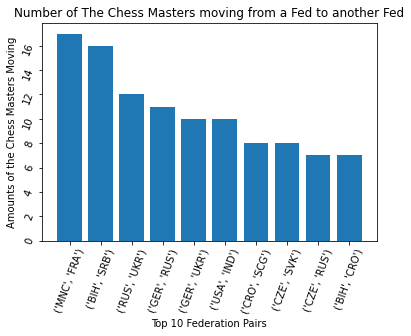

In [11]:
ks = [ str((x[0],x[1])) for x in zip(list(dfTop10.iloc[:,0]),list(dfTop10.iloc[:,1]))]
vs = list(dfTop10.iloc[:,2])

plt.bar(ks,vs)
plt.title('Number of The Chess Masters moving from a Fed to another Fed')
plt.xlabel('Top 10 Federation Pairs')
plt.ylabel('Amounts of the Chess Masters Moving')
plt.rcParams['figure.figsize'] = 15,8
plt.tick_params(labelrotation=70)
plt.show()

Q1-4)  We construct a python dictionary which its keys are pairs of federations and its values are the number of chess masters moving between those federations.

In [12]:
dictPairs = dict(countFedPairs)
list(dictPairs.items())[:10]

[(('USA', 'PHI'), 4),
 (('BIH', 'CRO'), 7),
 (('BIH', 'YUG'), 1),
 (('ESA', 'HON'), 1),
 (('AUT', 'ISR'), 1),
 (('AUS', 'CAN'), 1),
 (('CAN', 'YUG'), 2),
 (('USA', 'AZE'), 2),
 (('CAN', 'ENG'), 1),
 (('ITA', 'GER'), 2)]

Q1-5) We filter the dictionary and retain only the pairs that appear 5 or more times.

In [13]:
edges = [x for x in dictPairs if dictPairs[x] >= 5]
edges[:5]

[('BIH', 'CRO'),
 ('SUI', 'GER'),
 ('UKR', 'RUS'),
 ('GER', 'RUS'),
 ('USA', 'UKR')]

Q1-6) We plot the directed graph according to the related edges.

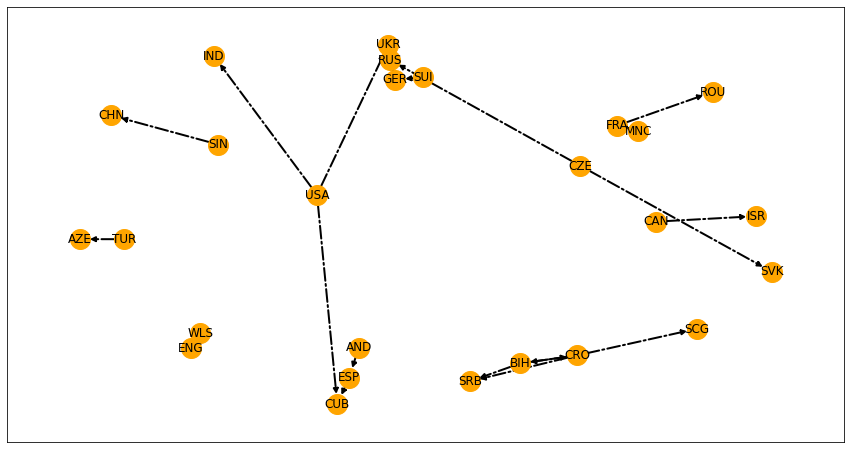

<Figure size 1440x0 with 0 Axes>

In [14]:
options = {
    'node_color': 'orange',
    'node_size': 400,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 10,
    'alpha': 1,
    'style': '-.',
}

G = nx.DiGraph()

G.add_edges_from(edges)
nx.draw_networkx(G, arrows=True, **options)

plt.figure(figsize=(20,0))
plt.show()

# Q2

## NBA Players

For this question we are going to use the following dataset:

In [15]:
NBA = pd.read_csv('https://sports-statistics.com/database/basketball-data/nba/2018-19_pbp.csv')
NBA

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,2,21800794,NaN,NaN,12:00,1,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:11 PM
1,1,0,10,4,21800794,Jump Ball Ayton vs. Faried: Tip to Okobo,NaN,12:00,1,4.0,5,4,1629028,Deandre Ayton,PHX,Phoenix,1.610613e+09,Suns,202702,Kenneth Faried,HOU,Houston,1.610613e+09,Rockets,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,NaN,NaN,NaN,9:11 PM
2,2,1,5,7,21800794,Jackson Bad Pass Turnover (P1.T1),NaN,11:39,1,4.0,5,0,1628367,Josh Jackson,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harden STEAL (1 STL),9:11 PM
3,3,6,1,9,21800794,NaN,NaN,11:31,1,5.0,0,0,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Harden 3' Driving Layup (2 PTS),9:12 PM
4,4,2,6,10,21800794,Bridges S.FOUL (P1.T1) (E.Dalen),NaN,11:31,1,4.0,5,1,1628969,Mikal Bridges,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:12 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,431,1,9,634,21801037,NaN,NaN,0:04,4,3.0,0,0,1610612739,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM
582464,432,0,8,635,21801037,NaN,NaN,0:04,4,5.0,5,0,1627790,Ante Zizic,CLE,Cleveland,1.610613e+09,Cavaliers,203903,Jordan Clarkson,CLE,Cleveland,1.610613e+09,Cavaliers,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB: Clarkson FOR Zizic,10:50 PM
582465,433,63,2,638,21801037,NaN,NaN,0:02,4,5.0,0,0,203917,Nik Stauskas,CLE,Cleveland,1.610613e+09,Cavaliers,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM
582466,434,0,4,639,21801037,Kleber REBOUND (Off:5 Def:7),NaN,0:02,4,4.0,0,0,1628467,Maxi Kleber,DAL,Dallas,1.610613e+09,Mavericks,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:51 PM


The data contains play-by-play information about all games from the 2018-2019 NBA season. We are interested in the columns 'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER3_ID', 'PLAYER3_NAME'. If the specific entry involves two or more players PLAYER2_ID, PLAYER2_NAME, PLAYER3_ID, PLAYER3_NAME are going to be non-empty. 

1. Construct a list of pairs that contains pairs of player names in interaction. If the play-by-play involves 3 players A,B and C you must have 3 entries: (A,B), (A,C) and (B,C) (write the pairs in the dictionary order).
2. Construct a python  dictionary where the keys are pairs of player names and the values are the number of times each pair appears in the list you constructed in step 1.
3. Filter the list and keep only the entries that appear more than 74 times (i.e. 75 or more).
4. Construct a `igraph` graph from the data you obtained from step 3.
5. Display the graph.
6. List the maximal cliques using the `maximal_cliques` of the graph data structure.

I pick the data where there exist infos about Player2 or Player3. By doing this process, we are narrowing the search scale.

In [16]:
condition1 = ~(NBA['PLAYER2_NAME'].isnull())
condiiton2 = (NBA['PLAYER2_ID'] != 0)
condition3 = ~(NBA['PLAYER3_NAME'].isnull())
condition4 = (NBA['PLAYER3_ID'] != 0)

#newNBA = NBA.loc[condition1 & condition2 & condition3 & condition4]
newNBA = NBA.loc[ condition1 | condition3 ]
newNBA.head(10)

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
1,1,0,10,4,21800794,Jump Ball Ayton vs. Faried: Tip to Okobo,NaN,12:00,1,4.0,5,4,1629028,Deandre Ayton,PHX,Phoenix,1.610613e+09,Suns,202702,Kenneth Faried,HOU,Houston,1.610613e+09,Rockets,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,NaN,NaN,NaN,9:11 PM
2,2,1,5,7,21800794,Jackson Bad Pass Turnover (P1.T1),NaN,11:39,1,4.0,5,0,1628367,Josh Jackson,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harden STEAL (1 STL),9:11 PM
4,4,2,6,10,21800794,Bridges S.FOUL (P1.T1) (E.Dalen),NaN,11:31,1,4.0,5,1,1628969,Mikal Bridges,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:12 PM
7,7,1,6,15,21800794,NaN,NaN,11:13,1,5.0,4,1,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,1626164,Devin Booker,PHX,Phoenix,1.610613e+09,Suns,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harden P.FOUL (P1.T1) (T.Maddox),9:13 PM
8,8,1,5,17,21800794,Okobo Bad Pass Turnover (P1.T2),NaN,11:05,1,4.0,5,0,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,203516,James Ennis III,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ennis III STEAL (1 STL),9:13 PM
10,10,1,6,20,21800794,NaN,NaN,10:43,1,5.0,4,1,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,1629028,Deandre Ayton,PHX,Phoenix,1.610613e+09,Suns,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harden P.FOUL (P2.T2) (E.Dalen),9:13 PM
19,19,2,6,30,21800794,Jackson S.FOUL (P1.T2) (E.Dalen),NaN,9:42,1,4.0,5,1,1628367,Josh Jackson,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:15 PM
21,21,3,1,33,21800794,Ayton 8' Hook Shot (2 PTS) (Okobo 1 AST),NaN,9:19,1,4.0,4,0,1629028,Deandre Ayton,PHX,Phoenix,1.610613e+09,Suns,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,0,NaN,NaN,NaN,NaN,NaN,7 - 4,-3,NaN,9:16 PM
22,22,108,1,35,21800794,NaN,NaN,9:08,1,5.0,5,0,202702,Kenneth Faried,HOU,Houston,1.610613e+09,Rockets,101108,Chris Paul,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,9 - 4,-5,Faried 2' Cutting Dunk Shot (2 PTS) (Paul 1 AST),9:16 PM
23,23,1,5,37,21800794,Okobo Bad Pass Turnover (P2.T3),NaN,8:59,1,4.0,5,0,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,101108,Chris Paul,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paul STEAL (1 STL),9:16 PM


Q2-1) We get the pairs (A,B), (A,C) and (B,C) and store them in res. Also for labeling the graph meaningful, we take the names corresponding to IDs.

In [17]:
res = []
namepairs = {}
cols = ['PLAYER1_ID','PLAYER1_NAME','PLAYER2_ID','PLAYER2_NAME','PLAYER3_ID','PLAYER3_NAME']
df = newNBA[cols].reset_index()

#edges = Counter([(x,y) for x,y in zip(chess['Federation'],chess['Form.Fed'])])
#edges

for index, row in df.iterrows():
    id_player1 = row['PLAYER1_ID']
    id_player2 = row['PLAYER2_ID']
    id_player3 = row['PLAYER3_ID']
    name_player1 = row['PLAYER1_NAME']
    name_player2 = row['PLAYER2_NAME']
    name_player3 = row['PLAYER3_NAME']
    
    existPlayer2 = id_player2 != 0
    existPlayer3 = id_player3 != 0
    
    if (existPlayer2):
        tuple1 = (id_player1,id_player2)
        res.append(tuple1)
        namepairs[str(id_player1)] = name_player1
    
    if (existPlayer3):
        tuple2 = (id_player1,id_player3)
        res.append(tuple2)
        namepairs[str(id_player2)] = name_player2
    
    if (existPlayer2 & existPlayer3):
        tuple3 = (id_player2,id_player3)
        res.append(tuple3)
        namepairs[str(id_player3)] = name_player3 
        

In [18]:
res[:10]

[(1629028, 202702),
 (1629028, 1629059),
 (202702, 1629059),
 (1628367, 201935),
 (1628969, 201935),
 (201935, 1626164),
 (1629059, 203516),
 (201935, 1629028),
 (1628367, 201935),
 (1629028, 1629059)]

Q2-2) We construct a python dictionary where the keys are pairs of player names and the values are the number of times each pair appears in the list we constructed in step 1.

In [19]:
counts = Counter(res)
dictEdges = {}

for x,y in counts.keys():
    if (y,x) in dictEdges:
        dictEdges[y,x] = counts[x,y] + counts[y,x]
    elif not (x,y) in dictEdges:
        dictEdges[x,y] = counts[x,y]

list(dictEdges.items())[:10]

[((1629028, 202702), 1),
 ((1629028, 1629059), 32),
 ((202702, 1629059), 3),
 ((1628367, 201935), 8),
 ((1628969, 201935), 11),
 ((201935, 1626164), 4),
 ((1629059, 203516), 1),
 ((201935, 1629028), 13),
 ((202702, 101108), 39),
 ((1629059, 101108), 4)]

Q2-3) We filter the list and keep only the entries that appear more than 74 times.

In [20]:
edges = [[x,y,dictEdges[x,y]] for x,y in dictEdges if dictEdges[x,y]>74]
edges[:10]

[[201935, 101108, 135],
 [1626164, 1628969, 111],
 [101123, 201935, 87],
 [200782, 101108, 83],
 [101123, 101108, 95],
 [1626164, 2037, 95],
 [2037, 1628969, 82],
 [1626158, 1629028, 220],
 [1629028, 1626164, 134],
 [1628969, 1628367, 110]]

Q2-4) We construct a igraph graph from the data we obtained from step 3.

We get IDs for vertices.

In [21]:
IDs = []

for x,y,z in edges:
    if not x in IDs:
        IDs.append(x)
    if not y in IDs:
        IDs.append(y)
        
IDs[:10]

[201935,
 101108,
 1626164,
 1628969,
 101123,
 200782,
 2037,
 1626158,
 1629028,
 1628367]

In [22]:
#pip install pycairo

And we convert the pairs and IDs to String type.

In [23]:
strEdges = [(str(x), str(y)) for x,y,z in edges]
strIDs = [str(x) for x in IDs]

In [24]:
G = ig.Graph()

G.add_vertices(strIDs)
G.add_edges(strEdges)

strnames = [namepairs[x] for x in strIDs]
G.vs['label'] = strnames

Q2-5) We plot the graph.

The clusters we see here represent players playing on the same team during the 2019 season.

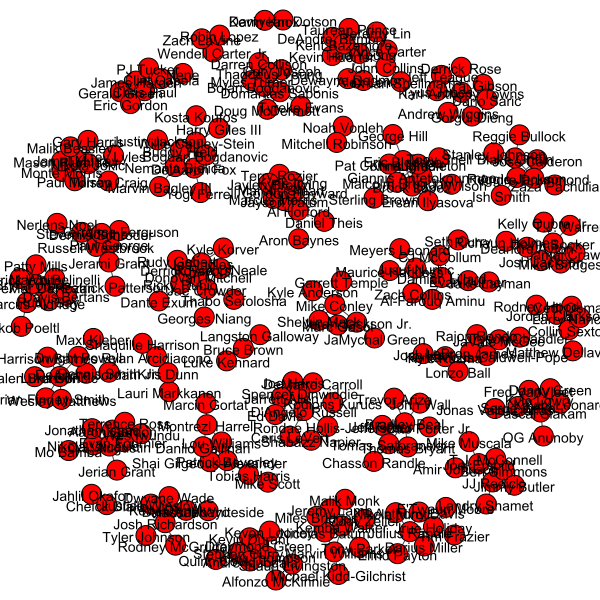

In [25]:
ig.plot(G)

Let's take an example from a cluster. We can see that Kyle Kuzma and Josh Hart are in the same team Los Angeles in the 2019 season.

In [26]:
checkdf = NBA.loc[(NBA['PLAYER1_NAME'] == 'Kyle Kuzma') | (NBA['PLAYER1_NAME']== 'Josh Hart')]
pd.unique(checkdf[['PLAYER1_NAME', 'PLAYER1_TEAM_CITY']].values.ravel('K'))

array(['Kyle Kuzma', 'Josh Hart', 'Los Angeles'], dtype=object)

Q2-6) We take the maximal cliques of the graph G.

In [27]:
G.maximal_cliques()

[(26, 25),
 (169, 170),
 (65, 60),
 (30, 29),
 (98, 97),
 (253, 140),
 (197, 196),
 (33, 32),
 (251, 77),
 (103, 104),
 (198, 128),
 (170, 168),
 (163, 119),
 (107, 100),
 (250, 140),
 (201, 66),
 (249, 221),
 (248, 225),
 (247, 2),
 (246, 193),
 (114, 108),
 (115, 116),
 (245, 153),
 (66, 67),
 (203, 202),
 (239, 208),
 (164, 15),
 (173, 167),
 (237, 156),
 (123, 119),
 (124, 125),
 (160, 155),
 (175, 174),
 (7, 8),
 (166, 134),
 (209, 208),
 (10, 2),
 (47, 41),
 (244, 176),
 (243, 242),
 (50, 41),
 (210, 208),
 (211, 212),
 (138, 139),
 (139, 213),
 (51, 48),
 (141, 140),
 (258, 99),
 (53, 43),
 (257, 242),
 (177, 104),
 (178, 131),
 (147, 140),
 (179, 167),
 (149, 62),
 (215, 104),
 (158, 153),
 (63, 62),
 (56, 57),
 (256, 205),
 (255, 205),
 (218, 196),
 (219, 71),
 (227, 222),
 (182, 59),
 (183, 180),
 (68, 61),
 (69, 59),
 (184, 60),
 (254, 204),
 (64, 61),
 (236, 154),
 (235, 21),
 (18, 15),
 (234, 233),
 (233, 228),
 (232, 229),
 (20, 19),
 (80, 54),
 (81, 45),
 (82, 43),
 (83,

# Q3

## Charles Dickens' *Great Expectations*

For this question we are going to use the following dataset:

In [28]:
with urlopen('https://www.gutenberg.org/files/1400/1400-0.txt') as f:
    raw = f.read()

greatExpectations = raw[1900:1039269].decode('utf8')
greatExpectations[:2000]

'\r\n\r\nMy father’s family name being Pirrip, and my Christian name Philip, my\r\ninfant tongue could make of both names nothing longer or more explicit\r\nthan Pip. So, I called myself Pip, and came to be called Pip.\r\n\r\nI give Pirrip as my father’s family name, on the authority of his\r\ntombstone and my sister,—Mrs. Joe Gargery, who married the blacksmith.\r\nAs I never saw my father or my mother, and never saw any likeness of\r\neither of them (for their days were long before the days of\r\nphotographs), my first fancies regarding what they were like were\r\nunreasonably derived from their tombstones. The shape of the letters on\r\nmy father’s, gave me an odd idea that he was a square, stout, dark man,\r\nwith curly black hair. From the character and turn of the inscription,\r\n“_Also Georgiana Wife of the Above_,” I drew a childish conclusion that\r\nmy mother was freckled and sickly. To five little stone lozenges, each\r\nabout a foot and a half long, which were arranged in a

These are the names of the major characters in the novel:

In [29]:
names = [
 'Joe',
 'Pip',
 'Wopsle',
 'Hubble',
 'Pumblechook',
 'Richard',
 'Wopsle',
 'Biddy',
 'Havisham',
 'Joseph',
 'Sarah',
 'Estella',
 'Orlick',
 'Mike',
 'Wemmick',
 'Herbert',
 'Pocket',
 'Jane',
 'Flopson',
 'Coiler',
 'Drummle',
 'Jack',
 'Spider',
 'Handel',
 'Herbert',
 'Clara',
 'Skiffins',
 'Magwitch',
 'Provis',
 'Compeyson',
 'Tom',
 'Bill',
 'Barley',
 'Orlick',
 'William']

names = set(sorted(names))
names

{'Barley',
 'Biddy',
 'Bill',
 'Clara',
 'Coiler',
 'Compeyson',
 'Drummle',
 'Estella',
 'Flopson',
 'Handel',
 'Havisham',
 'Herbert',
 'Hubble',
 'Jack',
 'Jane',
 'Joe',
 'Joseph',
 'Magwitch',
 'Mike',
 'Orlick',
 'Pip',
 'Pocket',
 'Provis',
 'Pumblechook',
 'Richard',
 'Sarah',
 'Skiffins',
 'Spider',
 'Tom',
 'Wemmick',
 'William',
 'Wopsle'}

1. Split the text into sentences using a sentence tokenizer from your favorite NLP library.
2. Construct a list of pairs of names: a pair of names (A,B) appears in the list if and only if both A and B appears in the same sentence. When you store the pair (A,B) in the list make sure A appears before B in the alphabetical order.
3. Construct a python dictionary where the keys are pairs of names and values are the number of times each pair appears in the list you constructed in step 2.
4. Filter the list and retain only those pairs that appear more than twice (i.e. 3 or more).
5. Construct a `networkx` graph using the pairs you have from step 4.
6. Display the graph.

Q3-1) Previously on Homework 3, we defined a function that gives the cleaned sentences from a text.

In [30]:
import regex as re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [31]:
def processText(text):
    raw_sentences = sent_tokenize(text)
    raw_words = word_tokenize(text)
    
    res_text = {'sentences': raw_sentences,
                    'words': raw_words}
    
    res_text.update({'cleanedSentences': [re.sub(r'[^\p{Letter}\s]','',sentence.lower()).replace('\n',' ').replace('\r',' ') for sentence in res_text['sentences']]})
    
    tmp = [re.sub(r'[^\p{Letter}]','',word.lower()) for word in res_text['words']]
    words_stripped = [s.strip() for s in tmp]
    words_nonempty = list(filter(lambda x: x != '', words_stripped))
    res_text.update({'cleanedWords': words_nonempty})
    

    return res_text

Now, we use this function to get the cleaned sentences.

In [32]:
dicttext = processText(greatExpectations)
sentences = dicttext['cleanedSentences']

sentences[:10]

['    my fathers family name being pirrip and my christian name philip my  infant tongue could make of both names nothing longer or more explicit  than pip',
 'so i called myself pip and came to be called pip',
 'i give pirrip as my fathers family name on the authority of his  tombstone and my sistermrs',
 'joe gargery who married the blacksmith',
 'as i never saw my father or my mother and never saw any likeness of  either of them for their days were long before the days of  photographs my first fancies regarding what they were like were  unreasonably derived from their tombstones',
 'the shape of the letters on  my fathers gave me an odd idea that he was a square stout dark man  with curly black hair',
 'from the character and turn of the inscription  also georgiana wife of the above i drew a childish conclusion that  my mother was freckled and sickly',
 'to five little stone lozenges each  about a foot and a half long which were arranged in a neat row beside  their grave and were sa

Q3-2) We iterate through single names for 2 times to get the pairs of names with alphabetical ascending order.

In [33]:
sortedNamePairs = []
for x in names:
    for y in names:
        x = x.lower()
        y = y.lower()
        if x == y:
            continue
        if (x,y) and (y,x) not in sortedNamePairs:
            if (x<y):
                tuuple = (x,y)
            elif (y<x):
                tuuple = (y,x)
            sortedNamePairs.append(tuuple)

sortedNamePairs[:20]

[('magwitch', 'richard'),
 ('coiler', 'richard'),
 ('clara', 'richard'),
 ('richard', 'wopsle'),
 ('joseph', 'richard'),
 ('flopson', 'richard'),
 ('herbert', 'richard'),
 ('pocket', 'richard'),
 ('havisham', 'richard'),
 ('estella', 'richard'),
 ('joe', 'richard'),
 ('pip', 'richard'),
 ('richard', 'skiffins'),
 ('handel', 'richard'),
 ('bill', 'richard'),
 ('biddy', 'richard'),
 ('richard', 'spider'),
 ('drummle', 'richard'),
 ('jack', 'richard'),
 ('richard', 'tom')]

We look at whether the elements of each noun pair match in any sentence at the same time, and we store them.

In [34]:
res = []

for x,y in sortedNamePairs:
    X1 = x+" "
    X2 = x+"s "
    Y1 = y+" "
    Y2 = y+"s "
    for sentence in sentences:
        if ((X1 in sentence)|(X2 in sentence)):
            if ((Y1 in sentence)|(Y2 in sentence)):
                res.append([x,y,sentence])
res

[['richard',
  'wopsle',
  'mr wopsle said grace with  theatrical declamationas it now appears to me something like a  religious cross of the ghost in hamlet with richard the thirdand  ended with the very proper aspiration that we might be truly grateful'],
 ['richard',
  'wopsle',
  'having his hand in mr wopsle finished off with a most  terrifically snarling passage from richard the third and seemed to  think he had done quite enough to account for it when he added as  the poet says    and here i may remark that when mr wopsle referred to me he  considered it a necessary part of such reference to rumple my hair and  poke it into my eyes'],
 ['jack',
  'richard',
  'without mentioning any names or going into any  details i gave him to understand that if he was aware of anybodytom  jack or richardbeing about the chambers or about the immediate  neighbourhood he had better get tom jack or richard out of the way  while you were out of the way    he would be greatly puzzled what to do    

Then, we convert the stored ones to a DataFrame.

In [35]:
dfGreatExpectations = pd.DataFrame(res)
dfGreatExpectations

,0,1,2
0,richard,wopsle,mr wopsle said grace with theatrical declamat...
1,richard,wopsle,having his hand in mr wopsle finished off with...
2,jack,richard,without mentioning any names or going into any...
3,jack,richard,without going near it yourself you could alwa...
4,jack,richard,after a while and when it might be prudent if...
...,...,...,...
978,pumblechook,william,william said mr pumblechook mournfully put the...
979,pumblechook,william,william bring a watercress thank you said i...
980,pumblechook,william,you neednt bring any william i went on with...
981,mike,wemmick,as he imparted this melancholy circumstance t...


Q3-3) We construct a python dictionary where the keys are pairs of names and values are the number of times each pair appears in the list we constructed in step 2.

In [36]:
counts = Counter([(x,y) for x,y in zip(dfGreatExpectations[0],dfGreatExpectations[1])])

edgesGE = dict(counts)
edgesGE

{('richard', 'wopsle'): 2,
 ('jack', 'richard'): 8,
 ('richard', 'tom'): 4,
 ('richard', 'wemmick'): 1,
 ('compeyson', 'magwitch'): 4,
 ('coiler', 'herbert'): 1,
 ('coiler', 'pocket'): 2,
 ('clara', 'herbert'): 14,
 ('clara', 'havisham'): 1,
 ('clara', 'estella'): 1,
 ('clara', 'handel'): 2,
 ('bill', 'clara'): 4,
 ('clara', 'provis'): 2,
 ('barley', 'clara'): 12,
 ('herbert', 'wopsle'): 6,
 ('joe', 'wopsle'): 26,
 ('pip', 'wopsle'): 2,
 ('biddy', 'wopsle'): 10,
 ('jack', 'wopsle'): 4,
 ('tom', 'wopsle'): 2,
 ('orlick', 'wopsle'): 2,
 ('hubble', 'wopsle'): 8,
 ('pumblechook', 'wopsle'): 10,
 ('havisham', 'joseph'): 2,
 ('joe', 'joseph'): 6,
 ('joseph', 'pip'): 1,
 ('joseph', 'pumblechook'): 8,
 ('flopson', 'herbert'): 1,
 ('flopson', 'pocket'): 7,
 ('flopson', 'joe'): 1,
 ('flopson', 'jane'): 3,
 ('herbert', 'pocket'): 11,
 ('havisham', 'herbert'): 14,
 ('estella', 'herbert'): 16,
 ('herbert', 'joe'): 6,
 ('herbert', 'pip'): 2,
 ('handel', 'herbert'): 34,
 ('bill', 'herbert'): 4,
 ('bi

Q3-4) By filtering, we get the edges whose pairs appear more than 2 times in the DataFrame.

In [37]:
edgesGE = [ x for x in edgesGE if edgesGE[x]>2]
edgesGE

[('jack', 'richard'),
 ('richard', 'tom'),
 ('compeyson', 'magwitch'),
 ('clara', 'herbert'),
 ('bill', 'clara'),
 ('barley', 'clara'),
 ('herbert', 'wopsle'),
 ('joe', 'wopsle'),
 ('biddy', 'wopsle'),
 ('jack', 'wopsle'),
 ('hubble', 'wopsle'),
 ('pumblechook', 'wopsle'),
 ('joe', 'joseph'),
 ('joseph', 'pumblechook'),
 ('flopson', 'pocket'),
 ('flopson', 'jane'),
 ('herbert', 'pocket'),
 ('havisham', 'herbert'),
 ('estella', 'herbert'),
 ('herbert', 'joe'),
 ('handel', 'herbert'),
 ('bill', 'herbert'),
 ('biddy', 'herbert'),
 ('drummle', 'herbert'),
 ('herbert', 'tom'),
 ('herbert', 'provis'),
 ('barley', 'herbert'),
 ('herbert', 'wemmick'),
 ('havisham', 'pocket'),
 ('estella', 'pocket'),
 ('pip', 'pocket'),
 ('drummle', 'pocket'),
 ('pocket', 'sarah'),
 ('jane', 'pocket'),
 ('pocket', 'pumblechook'),
 ('pocket', 'wemmick'),
 ('estella', 'havisham'),
 ('havisham', 'joe'),
 ('havisham', 'pip'),
 ('biddy', 'havisham'),
 ('havisham', 'sarah'),
 ('havisham', 'pumblechook'),
 ('estella',

Q3-5) We construct the networkx graph with the edges.

In [38]:
HiringGraph = nx.from_edgelist(edgesGE)

Q3-6) Finally, we plot the graph by drawing circular network.

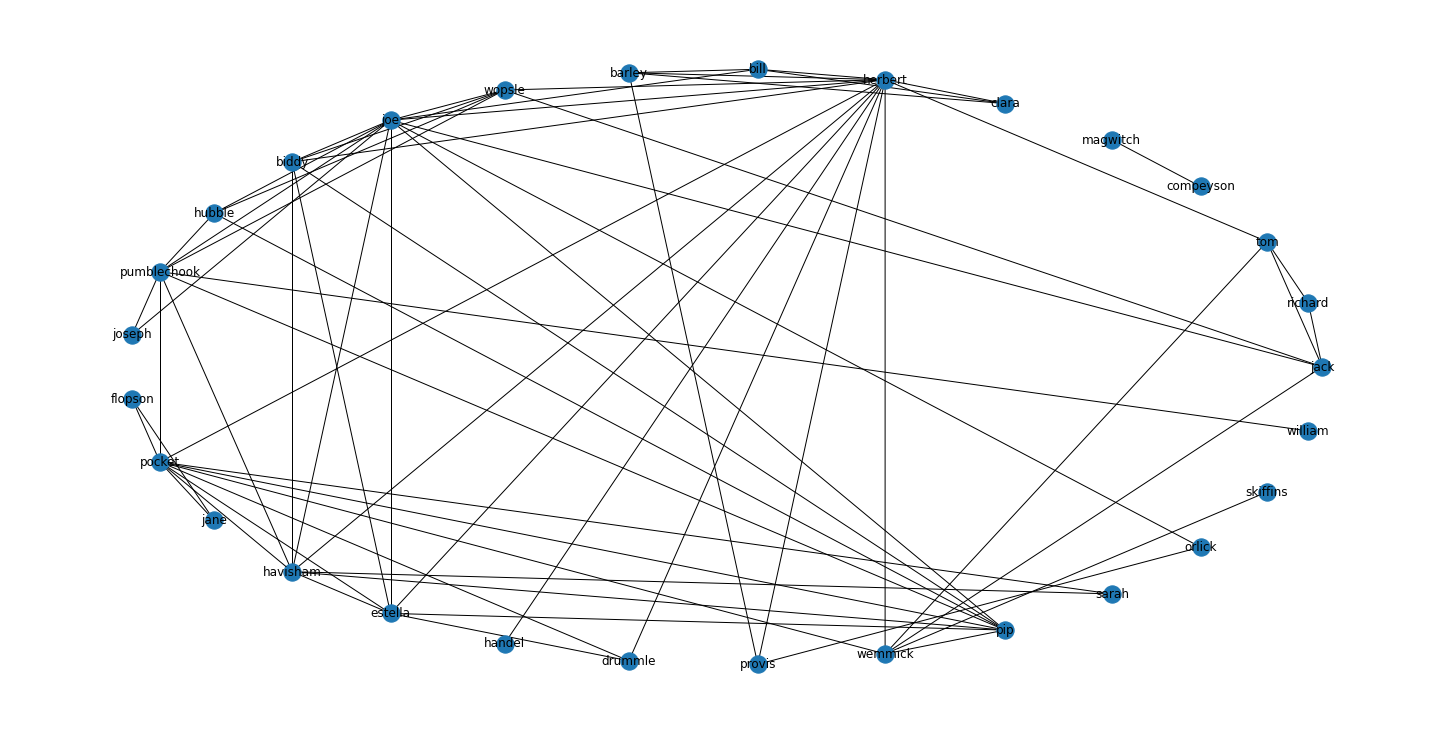

In [39]:
plt.figure(figsize=(20,10))
nx.draw_circular(HiringGraph,with_labels=True)